# Experiment with UNet Training

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import xarray as xr
from torch.utils.tensorboard import SummaryWriter

from rattlinbog.estimators.apply import apply
from rattlinbog.estimators.wetland_classifier import WetlandClassifier
from rattlinbog.pipeline.factory_functions import make_validation_log_cfg
from rattlinbog.pipeline.train import train
from rattlinbog.sampling.sample_patches_from_dataset import SamplingConfig
from rattlinbog.th_extensions.nn.unet import UNet
from rattlinbog.th_extensions.utils.dataset_splitters import GROUND_TRUTH_KEY, \
    PARAMS_KEY

## Data Loading

In [2]:
wetland_ds = xr.open_zarr("/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____WETLANDS-RPZ-AT-ROI-0-0-15000-15000_E051N015T3_EU020M__.zarr")

In [3]:
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
wetland_ds = wetland_ds.sel(parameter=param_selection)

In [4]:
train_ds = wetland_ds.isel(y=slice(0, 12000), x=slice(0, 15000))
valid_ds = wetland_ds.isel(y=slice(12000, 14000), x=slice(9000, 11000))
valid_ds[GROUND_TRUTH_KEY].min().values.item()

0.0

In [5]:
def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)


def preprocess_rgb_comp(x):
    o = x.copy()
    o[0, ...] = normalize(x[0], -np.pi, np.pi)
    o[1, ...] = normalize(np.clip((10 ** (x[1] / 10.0)), 1, 1.5), 1.0, 1.5)
    o[2, ...] = normalize(np.clip(x[2], -25, -8), -25, -8)
    return o

train_ds[PARAMS_KEY] = train_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=train_ds[PARAMS_KEY])
valid_ds[PARAMS_KEY] = valid_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=valid_ds[PARAMS_KEY])

In [6]:
train_ds = train_ds.persist()
valid_ds = valid_ds.persist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


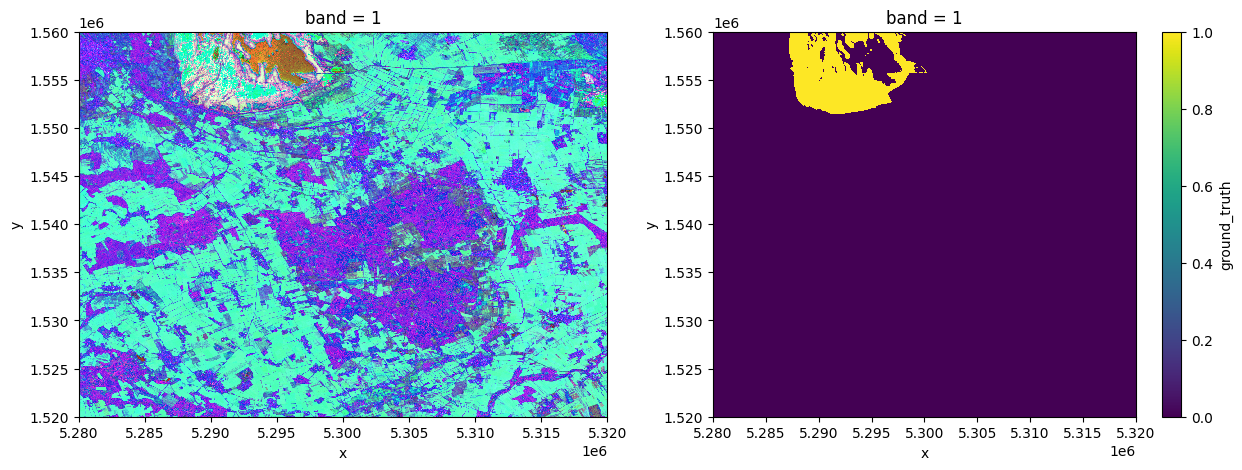

In [7]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
valid_ds[PARAMS_KEY].plot.imshow(ax=axes[0])
valid_ds[GROUND_TRUTH_KEY].plot(ax=axes[1])
plt.draw()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


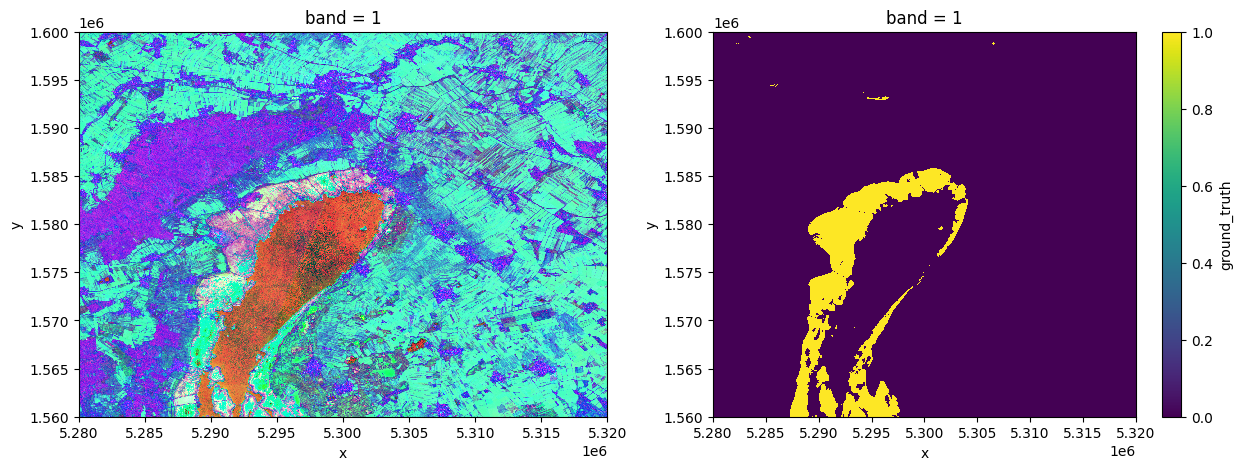

In [8]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
train_ds[PARAMS_KEY][:, 10000:12000, 9000:11000].plot.imshow(ax=axes[0])
train_ds[GROUND_TRUTH_KEY][10000:12000, 9000:11000].plot(ax=axes[1])
plt.draw()

## Train U-Net

In [9]:
unet = UNet(3, [64, 128, 256], 1).to(device=th.device('cuda'))

fit_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
train_writer = SummaryWriter(f"/tmp/simple-unet-runs/{fit_time}/train")
valid_writer = SummaryWriter(f"/tmp/simple-unet-runs/{fit_time}/valid")
log_cfg = make_validation_log_cfg(valid_ds, train_writer, valid_writer, 100, 624)

estimator = WetlandClassifier(unet, batch_size=16, log_cfg=log_cfg)

In [10]:
sampling_cfg = SamplingConfig(patch_size=16, n_samples=10000, never_nans=True)
train(estimator, train_ds, sampling_cfg)

fitting: 100%|██████████| 625/625 [01:48<00:00,  5.79it/s]


WetlandClassifier(batch_size=16,
                  log_cfg=LogConfig(log_sink=<torch.utils.tensorboard.writer.SummaryWriter object at 0x7fd07a4c4b80>,
                                    validation=ValidationLogging(log_sink=<torch.utils.tensorboard.writer.SummaryWriter object at 0x7fd07a4c4ee0>,
                                                                 source=<rattlinbog.evaluate.validation_source_from_dataset.ValidationSourceFromDataset object at 0x7fd07a4c52a0>,
                                                                 score...
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
    )
    (RemoveSkips): RemoveSkips()
  )
  (_prediction): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
))

In [11]:
estimate = apply(estimator).to(valid_ds['params'])
estimate.min().values.item()

2.904394750657957e-05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


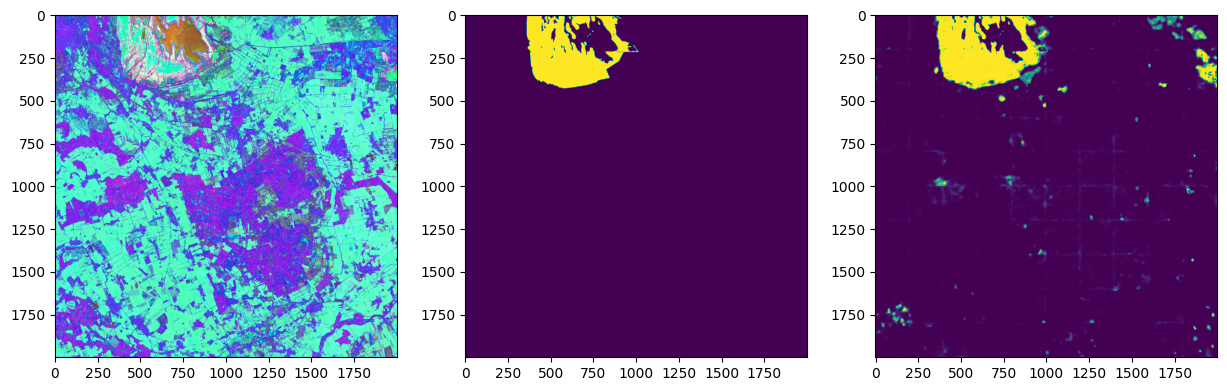

In [12]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(valid_ds[PARAMS_KEY].values.transpose((1, 2, 0)))
axes[1].imshow(valid_ds[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0])
plt.draw()